In [39]:
!pip install PeakUtils

In [40]:
import os
import peakutils
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from peakutils.plot import plot as pplot
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

In [41]:
df = pd.read_csv("../input/bmschlg/acceleration_data_in_bilbao_SP.csv")
df.head()

,time,acc_x,acc_y,acc_z,speed,latitude,longitude,heading,road_speed_limit,vehicle_make,vehicle_model,vehicle_type,road_type
0,2022-09-29 03:46:06.458,-0.030,-0.028,1.009,0.0,43.238934,-2.877811,318.0,40,MAN,TGX,truck,LOCAL_ROAD_OF_MAJOR_IMPORTANCE
1,2022-09-29 03:46:06.558,-0.032,-0.029,1.008,0.0,43.238934,-2.877811,318.0,40,MAN,TGX,truck,LOCAL_ROAD_OF_MAJOR_IMPORTANCE
2,2022-09-29 03:46:06.658,-0.029,-0.027,1.008,0.0,43.238934,-2.877811,318.0,40,MAN,TGX,truck,LOCAL_ROAD_OF_MAJOR_IMPORTANCE
3,2022-09-29 03:46:06.758,-0.028,-0.029,1.009,0.0,43.238934,-2.877811,318.0,40,MAN,TGX,truck,LOCAL_ROAD_OF_MAJOR_IMPORTANCE
4,2022-09-29 03:46:06.858,-0.030,-0.029,1.015,0.0,43.238934,-2.877811,318.0,40,MAN,TGX,truck,LOCAL_ROAD_OF_MAJOR_IMPORTANCE


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262443 entries, 0 to 262442
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   time              262443 non-null  object 
 1   acc_x             262443 non-null  float64
 2   acc_y             262443 non-null  float64
 3   acc_z             262443 non-null  float64
 4   speed             262443 non-null  float64
 5   latitude          262443 non-null  float64
 6   longitude         262443 non-null  float64
 7   heading           262443 non-null  float64
 8   road_speed_limit  262443 non-null  int64  
 9   vehicle_make      262443 non-null  object 
 10  vehicle_model     262443 non-null  object 
 11  vehicle_type      262443 non-null  object 
 12  road_type         262443 non-null  object 
dtypes: float64(7), int64(1), object(5)
memory usage: 26.0+ MB


In [43]:
df.nunique()

time                262443
acc_x                  529
acc_y                  549
acc_z                  853
speed                  546
latitude            161383
longitude           236781
heading             249852
road_speed_limit         9
vehicle_make             1
vehicle_model            1
vehicle_type             1
road_type                7
dtype: int64

In [44]:
df.drop(['vehicle_make', 'vehicle_model', 'vehicle_type'], axis=1, inplace=True)
df.road_type.unique()

array(['LOCAL_ROAD_OF_MAJOR_IMPORTANCE', 'CONNECTING_ROAD', 'MAJOR_ROAD',
       'SECONDARY_ROAD', 'MOTORWAY', 'MAJOR_ROAD_OF_HIGH_IMPORTANCE',
       'DESTINATION_ROAD'], dtype=object)

<AxesSubplot:xlabel='road_type'>

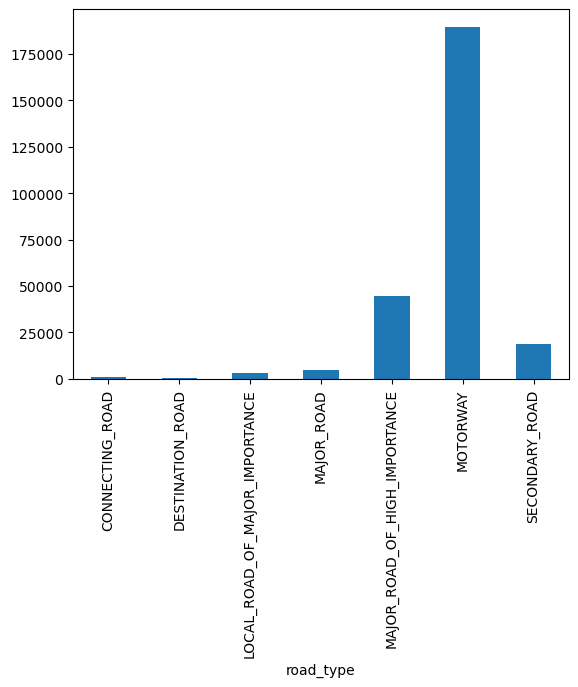

In [45]:
df.groupby('road_type')['road_type'].count().plot.bar()

In [46]:
df.groupby('road_type')['road_speed_limit'].unique()

road_type
CONNECTING_ROAD                                         [50, 90]
DESTINATION_ROAD                                        [90, 30]
LOCAL_ROAD_OF_MAJOR_IMPORTANCE                          [40, 30]
MAJOR_ROAD                                          [50, 90, 60]
MAJOR_ROAD_OF_HIGH_IMPORTANCE      [100, 90, 70, 40, 80, 60, 50]
MOTORWAY                          [120, 90, 70, 40, 80, 100, 60]
SECONDARY_ROAD                      [60, 80, 70, 40, 50, 30, 90]
Name: road_speed_limit, dtype: object

<AxesSubplot:>

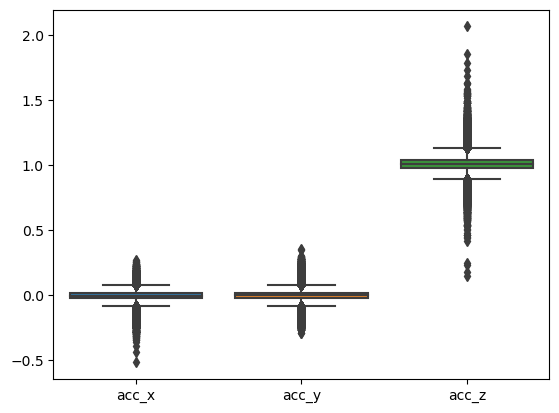

In [47]:
#sns.boxplot(x='road_speed_limit', y='speed',data=df)
sns.boxplot(data=df[['acc_x', 'acc_y', 'acc_z']])

def fig_from_df(df):
    fig = go.Figure()
    for col in df.columns:
      fig.add_trace(go.Scatter(x=df.index,y=df[col],name=col))
    return fig

fig = fig_from_df(df.loc[:,['acc_x','acc_y','acc_z']])
fig.write_html('time-history.html',full_html=False,include_plotlyjs='cdn')
fig.show()

<AxesSubplot:>

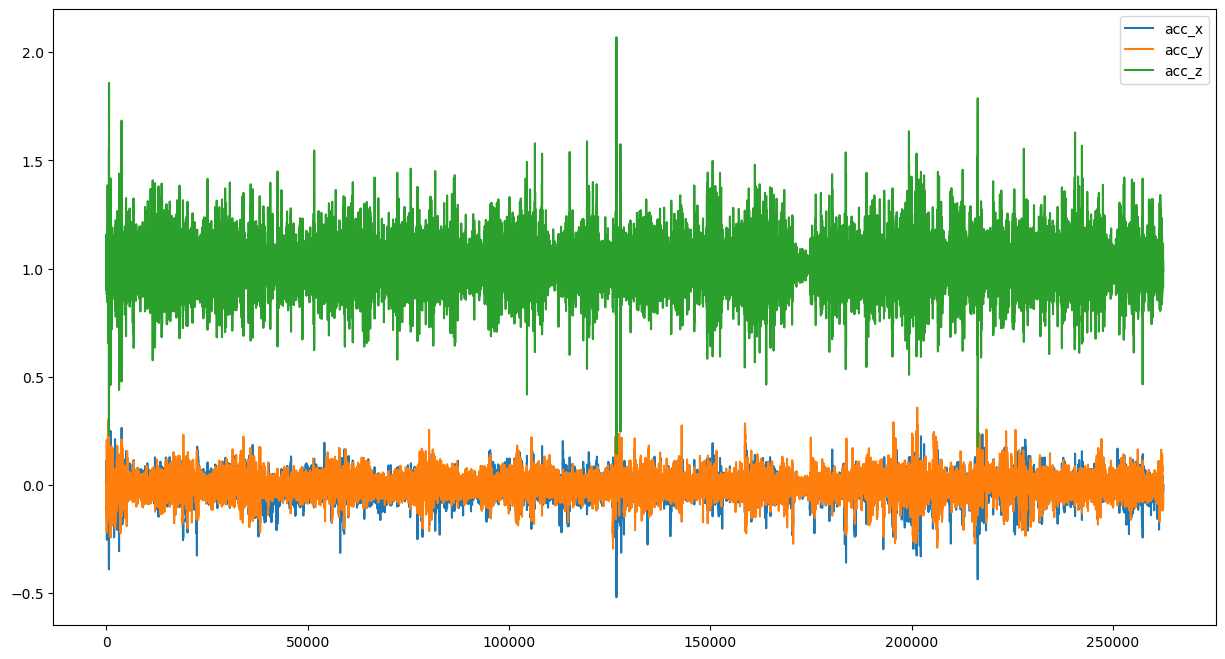

In [48]:
df.loc[:,['acc_x','acc_y','acc_z']].plot(figsize=(15,8))

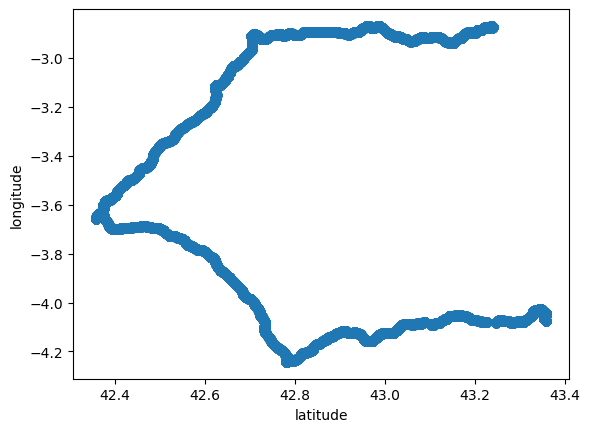

In [49]:
plt.scatter(df.latitude,df.longitude)
plt.xlabel("latitude")
plt.ylabel("longitude")
plt.show()

In [50]:
#sns.pairplot(df[['acc_x', 'acc_y', 'acc_z', 'speed']], hue='speed')

**Anomaly Detection**

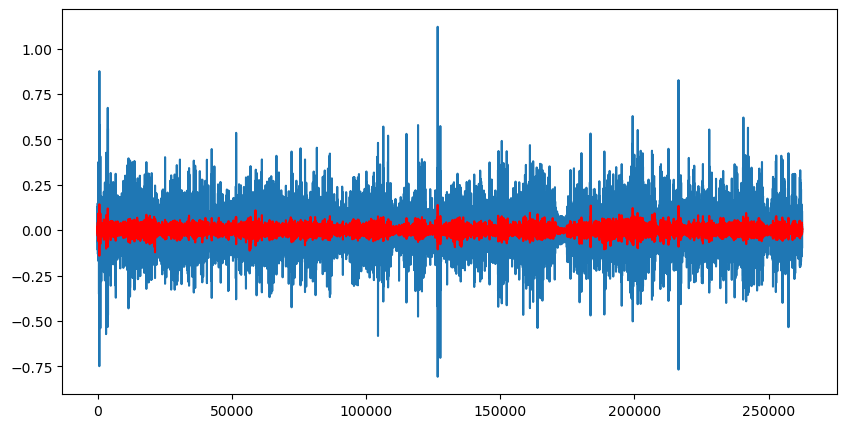

In [51]:
df['magmean'] = np.sqrt(np.square(df.acc_x) + np.square(df.acc_y) + np.square(df.acc_z)) - np.mean(np.sqrt(np.square(df.acc_x) + np.square(df.acc_y) + np.square(df.acc_z)))
# data = df[['acc_x', 'acc_y', 'acc_z', 'magmean']]
plt.figure(figsize = (10, 5))
rolling = df.magmean.rolling(window = 10)
rolling_mean = rolling.mean()
plt.plot(df.magmean)
plt.plot(rolling_mean, color = 'red')

**Pothole detection**

['2022-09-29 03:48:47.692' '2022-09-29 06:14:53.509'
 '2022-09-29 07:11:02.064' '2022-09-29 08:15:52.558'
 '2022-09-29 13:20:22.425'] 654       0.230
104459    0.418
126686    0.144
127675    0.246
216399    0.176
Name: acc_z, dtype: float64


Text(0, 0.5, 'Acceleration in the y direction')

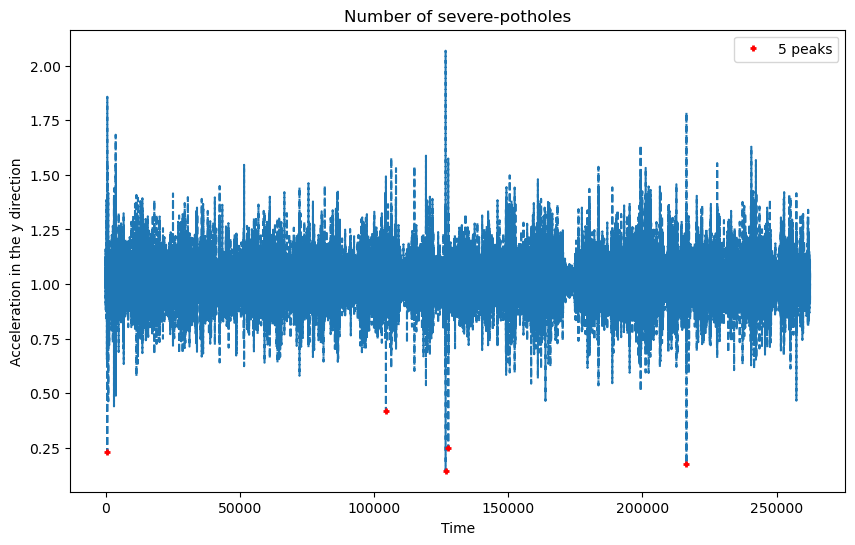

In [52]:
x = np.array(df.time)
#y = np.array(df.acc_z)
indexes = peakutils.indexes(-df.acc_z, thres=0.85, min_dist=10)
#print(indexes)
print(x[indexes], df.acc_z[indexes])
plt.figure(figsize=(10,6))
pplot(df.index, df.acc_z, indexes)
plt.title('Number of severe-potholes')
plt.xlabel('Time')
plt.ylabel('Acceleration in the y direction')

**speed breakers**

['2022-09-29 03:48:49.492' '2022-09-29 07:11:01.764'
 '2022-09-29 13:20:22.125'] 672       1.858
126683    2.069
216396    1.787
Name: acc_z, dtype: float64


Text(0, 0.5, 'Acceleration in the y direction')

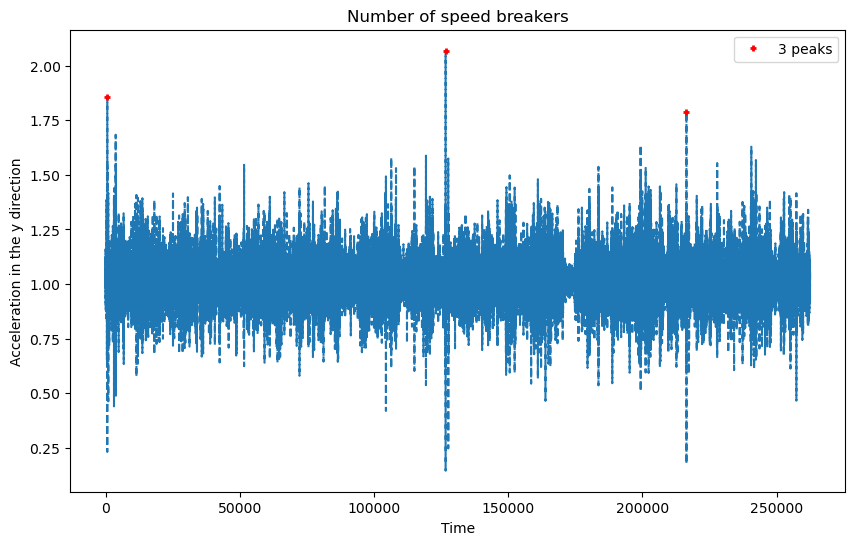

In [53]:
x = np.array(df.time)
#y = np.array(df.acc_z)
indexes = peakutils.indexes(df.acc_z, thres=0.85, min_dist=10)
#print(indexes)
print(x[indexes], df.acc_z[indexes])
plt.figure(figsize=(10,6))
pplot(df.index, df.acc_z, indexes)
plt.title('Number of speed breakers')
plt.xlabel('Time')
plt.ylabel('Acceleration in the y direction')

['2022-09-29 03:48:47.692' '2022-09-29 07:11:02.064'
 '2022-09-29 08:15:52.558' '2022-09-29 13:20:22.425'] 654      -0.749464
126686   -0.807834
127675   -0.703505
216399   -0.768291
Name: magmean, dtype: float64


Text(0, 0.5, 'Acceleration in the y direction')

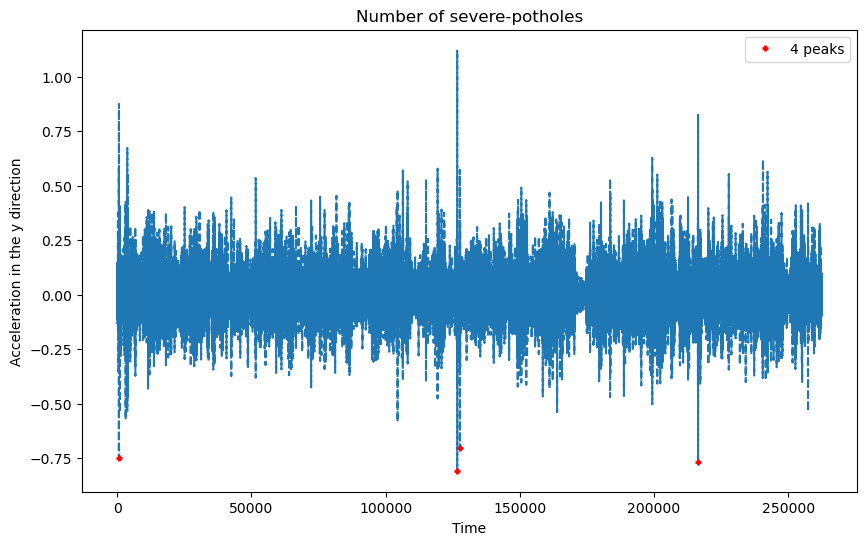

In [54]:
x = np.array(df.time)
y = np.array(df.acc_z)
indexes = peakutils.indexes(-df.magmean, thres=0.90, min_dist=10)
#print(indexes)
print(x[indexes], df.magmean[indexes])
plt.figure(figsize=(10,6))
pplot(df.index, df.magmean, indexes)
plt.title('Number of severe-potholes')
plt.xlabel('Time')
plt.ylabel('Acceleration in the y direction')

['2022-09-29 03:48:49.492' '2022-09-29 07:11:01.764'] 672       0.875565
126683    1.120011
Name: magmean, dtype: float64


Text(0, 0.5, 'Acceleration in the y direction')

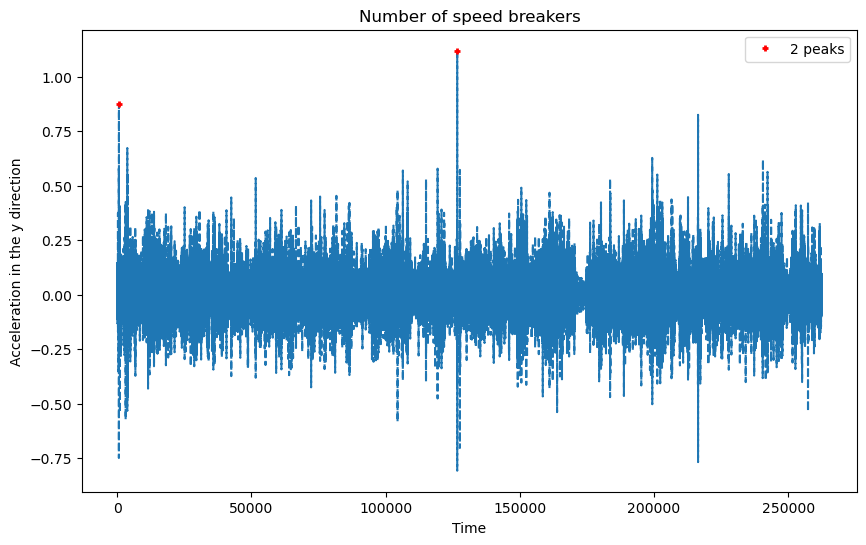

In [55]:
x = np.array(df.time)
y = np.array(df.acc_z)
indexes = peakutils.indexes(df.magmean, thres=0.85, min_dist=10)
#print(indexes)
print(x[indexes], df.magmean[indexes])
plt.figure(figsize=(10,6))
pplot(df.index, df.magmean, indexes)
plt.title('Number of speed breakers')
plt.xlabel('Time')
plt.ylabel('Acceleration in the y direction')

['2022-09-29 03:48:50.292' '2022-09-29 07:11:02.564'
 '2022-09-29 07:05:18.445' '2022-09-29 13:20:22.925'] 680       0.142418
126691    0.138607
183699    0.135129
216404    0.133479
Name: magmean, dtype: float64


Text(0, 0.5, 'Acceleration in the y direction')

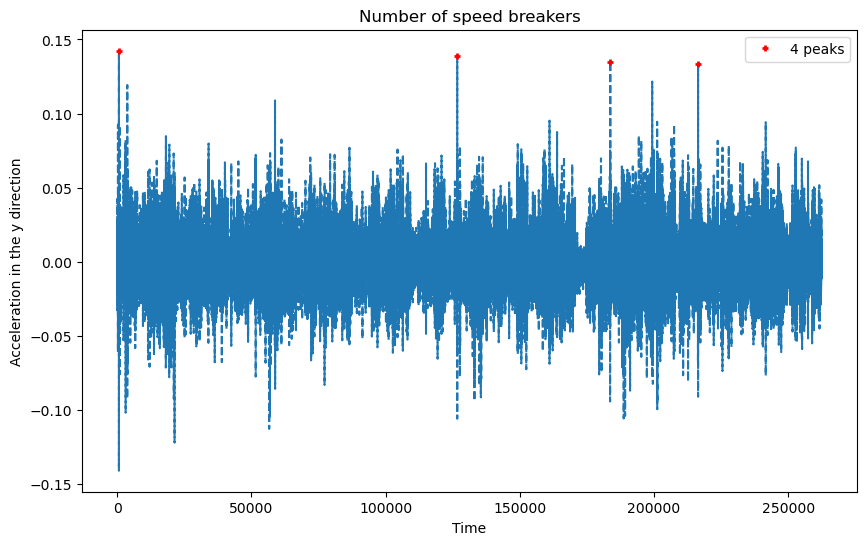

In [56]:
x = np.array(df.time)
y = np.array(df.acc_z)
indexes = peakutils.indexes(rolling_mean, thres=0.95, min_dist=10)
#print(indexes)
print(x[indexes], rolling_mean[indexes])
plt.figure(figsize=(10,6))
pplot(df.index, rolling_mean, indexes)
plt.title('Number of speed breakers')
plt.xlabel('Time')
plt.ylabel('Acceleration in the y direction')

['2022-09-29 03:48:49.192' '2022-09-29 08:49:33.130'
 '2022-09-29 12:50:24.244'] 669     -0.141080
21402   -0.122113
56647   -0.112859
Name: magmean, dtype: float64


Text(0, 0.5, 'Acceleration in the y direction')

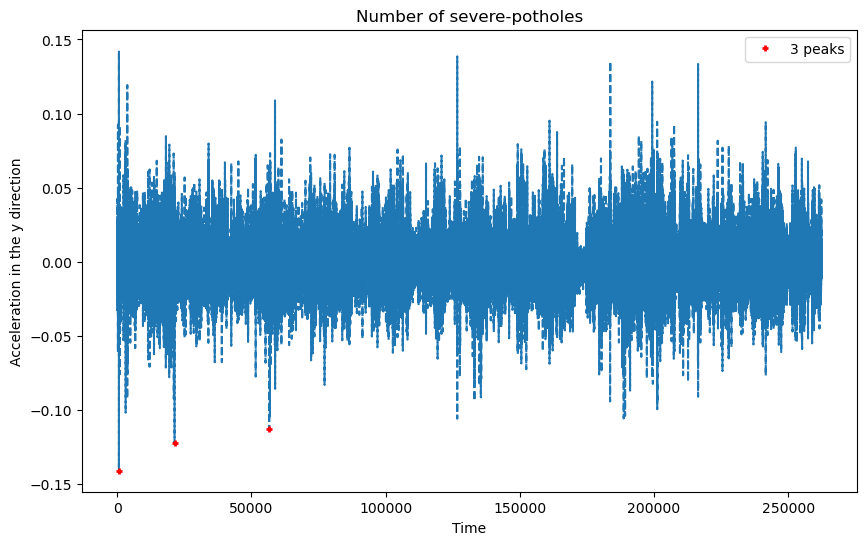

In [57]:
x = np.array(df.time)
y = np.array(df.acc_z)
indexes = peakutils.indexes(-rolling_mean, thres=0.90, min_dist=10)
#print(indexes)
print(x[indexes], rolling_mean[indexes])
plt.figure(figsize=(10,6))
pplot(df.index, rolling_mean, indexes)
plt.title('Number of severe-potholes')
plt.xlabel('Time')
plt.ylabel('Acceleration in the y direction')

**Modeling**

In [58]:
# Assuming 10% of the entire data set are anomalies 
outliers_fraction = 0.10
model=IsolationForest(contamination=outliers_fraction)
model.fit(df[['acc_x', 'acc_y', 'acc_z']]) 
df['anomaly'] = model.predict(df[['acc_x', 'acc_y', 'acc_z']])
df['scores']=model.decision_function(df[['acc_x', 'acc_y', 'acc_z']])

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [59]:
df.anomaly.value_counts()

 1    236198
-1     26245
Name: anomaly, dtype: int64

In [60]:
df[df['anomaly']==-1].head()

,time,acc_x,acc_y,acc_z,speed,latitude,longitude,heading,road_speed_limit,road_type,magmean,anomaly,scores
47,2022-09-29 03:46:43.158,0.017,-0.055,1.160,2.6,43.238934,-2.877812,318.14462,40,LOCAL_ROAD_OF_MAJOR_IMPORTANCE,0.147727,-1,-0.037579
53,2022-09-29 03:46:43.758,0.061,-0.053,0.949,2.6,43.238937,-2.877817,322.74800,40,LOCAL_ROAD_OF_MAJOR_IMPORTANCE,-0.061266,-1,-0.012081
54,2022-09-29 03:46:43.858,0.090,-0.021,0.932,2.6,43.238937,-2.877818,323.36570,40,LOCAL_ROAD_OF_MAJOR_IMPORTANCE,-0.077129,-1,-0.046361
55,2022-09-29 03:46:43.958,0.102,-0.014,0.973,2.6,43.238937,-2.877819,323.57678,40,LOCAL_ROAD_OF_MAJOR_IMPORTANCE,-0.035268,-1,-0.029258
56,2022-09-29 03:46:44.058,0.113,-0.008,0.969,6.7,43.238940,-2.877820,323.69380,40,LOCAL_ROAD_OF_MAJOR_IMPORTANCE,-0.038101,-1,-0.051491


In [61]:
df_train=df[['acc_x', 'acc_y', 'acc_z']]
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(df_train)
labels = kmeans.predict(df_train)
df_train['anomaly'] = labels
unique_elements, counts_elements = np.unique(labels, return_counts=True)
clusters = np.asarray((unique_elements, counts_elements))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


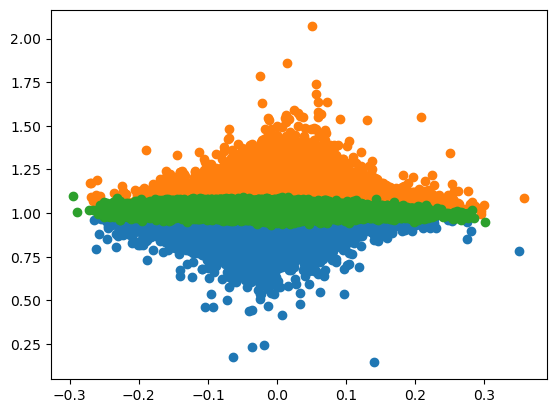

In [68]:
filtered_label0 = df_train[df_train['anomaly'] == 0]
filtered_label1 = df_train[df_train['anomaly'] == 1]
filtered_label2 = df_train[df_train['anomaly'] == 2]
#Plotting the results
plt.scatter(filtered_label0['acc_y'] , filtered_label0['acc_z'])
plt.scatter(filtered_label1['acc_y'] , filtered_label1['acc_z'])
plt.scatter(filtered_label2['acc_y'] , filtered_label2['acc_z'])
plt.show()

In [63]:
# function that calculates distance between each point and the centroid of the closest cluster
def getDistanceByPoint(data, model):
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index=data.index)

In [65]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(df_train[['acc_x', 'acc_y', 'acc_z']], kmeans)
# number of observations that equate to the 10% of the entire data set
number_of_outliers = int(outliers_fraction*len(distance))
# Take the minimum of the largest 10% of the distances as the threshold
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster
df_train['anomaly1'] = (distance >= threshold).astype(int)
df_train.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,acc_x,acc_y,acc_z,anomaly,anomaly1
0,-0.030,-0.028,1.009,2,0
1,-0.032,-0.029,1.008,2,0
2,-0.029,-0.027,1.008,2,0
3,-0.028,-0.029,1.009,2,0
4,-0.030,-0.029,1.015,2,0


In [69]:
df_train.anomaly1.value_counts()

0    236199
1     26244
Name: anomaly1, dtype: int64